In [1]:
!pip install textblob
!pip install regex
!pip install pyLDAvis==3.4.1
!pip install tdqm
!pip install wordninja

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#try 2.1.2 for pyLDAvis
# 2.0.0
# 1.5.1


In [13]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import os

import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.figure_factory as ff

import re
from tqdm import tqdm

#nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import wordninja

import pyLDAvis
pyLDAvis.enable_notebook()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrtcloud-8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mrtcloud-8/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mrtcloud-8/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
#Read and convert csv files to data frames
before_war = pd.read_csv("before_war.csv")
war_and_after = pd.read_csv("war_and_afterwards.csv")

In [21]:
'''
This function removes stopwords, tokenizes the text, and performs other basic text processing. 
I used wordninja to split the hashtags up into separate words 
The cleaned text will be stored in another column called cleaned_text.
# '''

from tqdm import tqdm  # Import tqdm library

# Set up stopwords
stop_words = set(stopwords.words('english'))

#add space before 'putin' in hashtags
def preprocess_hashtags(text):
    text = text.replace("#putin", "#put in")
    return text

def break_hashtags(text):
    text = preprocess_hashtags(text)
    #split hashtag words
    words = wordninja.split(text)
    return words

#ensure "putin" does not get broken up
def fix_putin(words):
    for i, word in enumerate(words):
        if word == 'put' and i < len(words)-1 and words[i+1] == 'in':
            words[i] = 'putin'
            del words[i+1]
    return words

#Clean the text data
def clean_text(text):
    #Remove any links via re
    text = re.sub(r'http\S+', ' ', text)

    #only accept alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    #split hashtags into separate words
    words = []
    for hashtag in text.split():
        broken_words = break_hashtags(hashtag)
        fixed_words = fix_putin(broken_words)
        words.extend(fixed_words)

    #Tokenize text and make everything lowercase
    tokens = word_tokenize(' '.join(words).lower())
    
    #Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    #Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    #Rejoin the tokens into a cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

tqdm.pandas()

#Clean the 'text' column and save cleaned text as 'cleaned_text'
# before_war['cleaned_text'] = before_war.apply(clean_text, axis=1)
# war_and_after['cleaned_text'] = war_and_after.apply(clean_text, axis=1)
# Clean the 'text' column and save cleaned text as 'cleaned_text'
before_war['cleaned_text'] = before_war['text'].progress_apply(clean_text)
war_and_after['cleaned_text'] = war_and_after['text'].progress_apply(clean_text)

100%|█████████████████████████████| 8268526/8268526 [1:34:50<00:00, 1453.04it/s]


In [43]:

# #pickle files
# before_war_cleaned = before_war
# war_and_after_cleaned = war_and_after
with open('before_war_cleaned.pkl', 'wb') as f:
    pickle.dump(before_war, f)
    
with open('war_and_after_cleaned.pkl', 'wb') as f:
    pickle.dump(war_and_after, f)


#make smaller datasets
#stratified random sampling for before_war dataset
before_war_sample = before_war.groupby('cleaned_text').apply(lambda x: x.sample(frac=0.5, random_state=42))

# #stratified random sampling for war_and_after dataset
war_and_after_sample = war_and_after.groupby('cleaned_text').apply(lambda x: x.sample(frac=0.2, random_state=42))



In [44]:
war_and_after_sample['cleaned_text']


6880054    tweet please russian army looter stole five sh...
5158431    unbeatable symbol european solidarity humanity...
4160604     russia ukraine captured ru tai fun k rap vehicle
2700668    ukraine nf z full segment fly zone debate nuan...
6049216    destroyed russia n convoy near tros ty net eas...
                                 ...                        
6312579    banality morrison morrison news ukraine russia...
5553361    russian force started practicing captured n la...
4825524    japan restriction japan self defense force org...
4815403    shame leroy merlin auch stop supporting put wa...
5224637    ukraine earlier today ukrainian force stuck kh...
Name: cleaned_text, Length: 1240279, dtype: object

In [45]:
#save stratified data
with open('before_war_sample.pkl', 'wb') as f:
    pickle.dump(before_war_sample, f)
with open('war_and_after_sample.pkl', 'wb') as f:
    pickle.dump(war_and_after_sample, f)


In [ ]:
before_war = before_war_sample
war_and_after = war_and_after_sample

In [ ]:
#Frequency of Posts by Year-Month

ym2 = before_war['date'].value_counts().sort_index() # get the counts for each year-month and sort them
plt.figure(figsize=(20,6))
sns.lineplot(x=ym2.index, y = ym2.values, color='green') # plot the line chart using seaborn
plt.title('Distribution of Tweets Before War', fontsize=15)

ym = war_and_after['date'].value_counts().sort_index() # get the counts for each year-month and sort them
plt.figure(figsize=(20,6))
sns.lineplot(x=ym.index, y = ym.values, color='green') # plot the line chart using seaborn
plt.title('Year-Month distribution of tweets', fontsize=15)

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


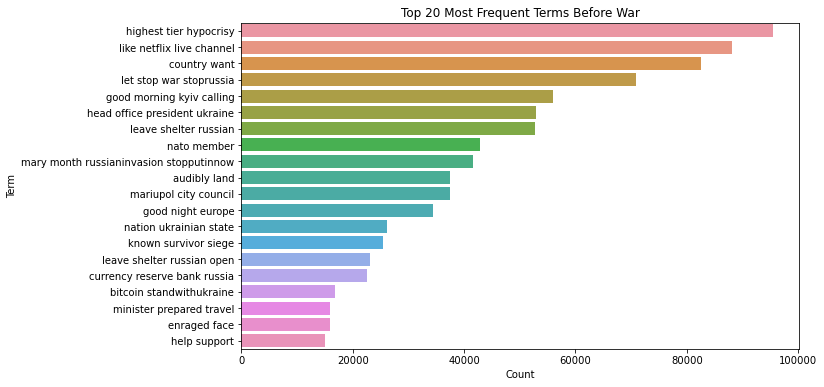

In [58]:
#Most frequent words in before_war

# Combine the counts of each token across all tweets
token_counts_before_war = np.array(before_war_tfidf.sum(axis=0))[0]

# Get indices of sorted token counts 
sorted_indices = np.argsort(token_counts_before_war)[::-1]

# Get unique terms/token from extracted text (vocab)from CountVectorizer
vocab_before_war = before_war_vect.get_feature_names_out()

# Get the most frequent terms and their counts
term_freq_before_war = [(vocab[i], token_counts_before_war[i]) for i in sorted_indices]

# Convert the most frequent terms to a DataFrame for visualization
most_frequent_df = pd.DataFrame(term_freq_before_war, columns=['Term', 'Count'])


# Plot the most frequent terms
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20))  # Adjust the number to display more or fewer terms
plt.title('Top 20 Most Frequent Terms Before War')
plt.xlabel('Count')
plt.ylabel('Term')
plt.show()


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


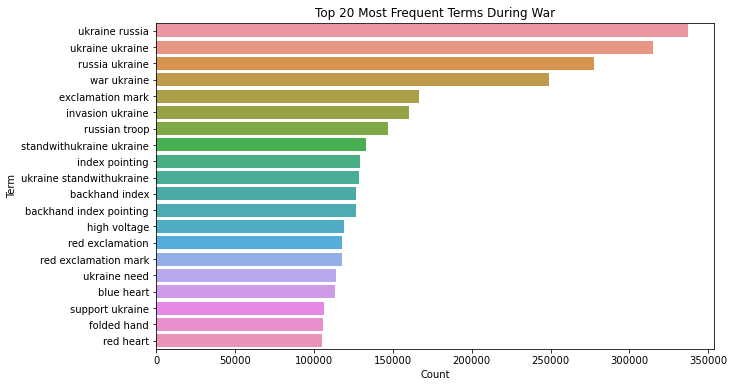

In [61]:
#Most frequent words in after_war

# Combine the counts of each token across all tweets
token_counts_war_and_after = np.array(war_and_after_tfidf.sum(axis=0))[0]

# Get indices of sorted token counts 
sorted_indices = np.argsort(token_counts_war_and_after)[::-1]

# Get unique terms/token from extracted text (vocab)from CountVectorizer
vocab = war_and_after_vect.get_feature_names_out()

# Get the most frequent terms and their counts
term_freq_war_and_after = [(vocab[i], token_counts_war_and_after[i]) for i in sorted_indices]

# Convert the most frequent terms to a DataFrame for visualization
most_frequent_df = pd.DataFrame(term_freq_war_and_after, columns=['Term', 'Count'])


# Plot the most frequent terms
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20))  # Adjust the number to display more or fewer terms
plt.title('Top 20 Most Frequent Terms During War')
plt.xlabel('Count')
plt.ylabel('Term')
plt.show()


In [46]:
with open('before_war_cleaned.pkl', 'rb') as f:
    before_war = pickle.load(f)
    print(before_war.shape)
with open('war_and_after_cleaned.pkl', 'rb') as f:
    war_and_after = pickle.load(f)
    print(war_and_after.shape)
    
with open('before_war_vect.pkl', 'rb') as f:
    before_war_vect = pickle.load(f)
with open('war_and_after_vect.pkl', 'rb') as f:
    war_and_after_vect = pickle.load(f)

with open('before_war_tfidf.pkl', 'rb') as f:
    before_war_tfidf = pickle.load(f)
with open('war_and_after_tfidf.pkl', 'rb') as f:
    war_and_after_tfidf = pickle.load(f)


(835142, 5)
(8268526, 5)


In [47]:
war_and_after_lda = LatentDirichletAllocation(n_components=9,
                                   max_iter=100,
                                   learning_method='online',
                                   random_state = 42)


war_and_after_lda.fit(war_and_after_tfidf)

LatentDirichletAllocation(learning_method='online', max_iter=100,
                          n_components=9, random_state=42)

In [48]:
# war_and_after_vect.fit(war_and_after_sample['cleaned_text'])
vocab_war_and_after = list(war_and_after_vect.get_feature_names_out())
#Read pickled after_war_LDAs

#max_iter = 160, n_components = 8 
import pyLDAvis.lda_model

visual_after = pyLDAvis.lda_model.prepare(war_and_after_lda, war_and_after_tfidf, war_and_after_vect, vocab=vocab_war_and_after )
visual_after

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.273300 -0.025721       1        1  17.243697
5      0.176741  0.123974       2        1  15.281658
6     -0.319503 -0.115994       3        1  10.538394
4      0.016150  0.089415       4        1  10.535883
0     -0.127475 -0.179374       5        1   9.719397
7      0.043420 -0.184715       6        1   9.479014
2     -0.130801  0.266452       7        1   9.412991
3      0.125839 -0.173736       8        1   8.897614
1     -0.057671  0.199699       9        1   8.891352, topic_info=                Term           Freq          Total Category  logprob  loglift
3118  russia ukraine  123247.000000  123247.000000  Default  30.0000  30.0000
4314  ukraine russia  143804.000000  143804.000000  Default  29.0000  29.0000
4446     ukraine war  119501.000000  119501.000000  Default  28.0000  28.0000
3153      russia war   80688.000000   80688.000000  Default  27.0000  27.0000
4827     war ukraine  111563.000000  111563.000000  Default  26.0000  26.0000
...              ...            ...            ...      ...      ...      ...
3632   stand ukraine   22116.035688  194229.912471   Topic9  -3.7479   0.2474
1729        kher son    5201.732142   16767.525793   Topic9  -5.1952   1.2496
3765    stop ukraine    3554.063059    5128.974769   Topic9  -5.5761   2.0533
3314   russian troop    3834.426605   21840.124172   Topic9  -5.5002   0.6804
4367   ukraine stand    3832.418729   23210.903559   Topic9  -5.5007   0.6190

[372 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
57        4  0.999694           aid ukraine
63        5  0.999705           air defense
83        3  0.999953       airlift ukraine
84        3  0.999906  airlift ukraine stop
160       6  0.999907             anti tank
...     ...       ...                   ...
4959      4  0.999871             world war
4963      4  0.999672              year ago
4967      4  0.999914              year old
4992      4  0.999672               zap ori
4999      2  0.999822          zone ukraine

[390 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 7, 5, 1, 8, 3, 4, 2])

In [49]:
with open('war_and_after_lda.pkl', 'wb') as f:
     pickle.dump(war_and_after_lda, f)

## Get Hyperparameters

### Before war

Calculating Log-Likelihoods: 100%|████████████| 14/14 [39:42<00:00, 170.18s/it]


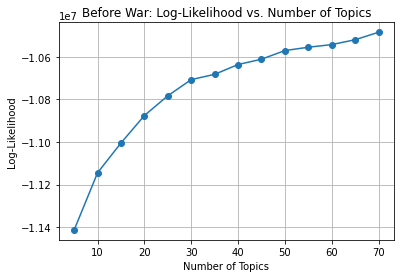

In [6]:
#GET NUM OF TOPICS BEFORE WAR
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_topics in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_topics = 5
max_topics = 70
step_size = 5
topic_range, log_likelihoods = calculate_log_likelihood(before_war_tfidf, min_topics, max_topics, step_size)

# Plot log-likelihoods
plt.figure(figsize=(12, 10))
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood')
plt.title('Before War: Log-Likelihood vs. Number of Topics')
plt.grid(True)
plt.show()


Calculating Log-Likelihoods: 100%|██████████| 16/16 [6:13:45<00:00, 1401.56s/it]


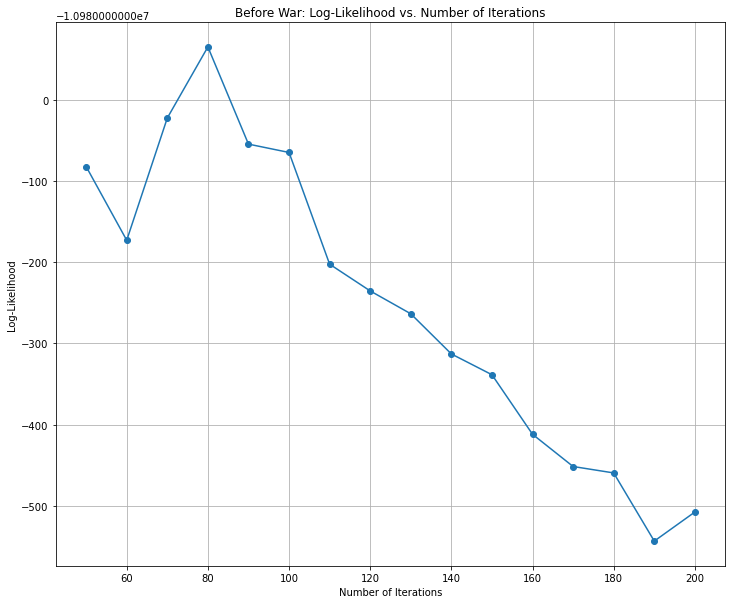

In [8]:
#BEFORE WAR ITERATIONS
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_iter in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=15, max_iter=num_iter, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_iter= 50
max_iter = 200
step_size = 10
topic_range, log_likelihoods = calculate_log_likelihood(before_war_tfidf, min_iter, max_iter, step_size)

plt.figure(figsize=(12, 10))
# Plot log-likelihoods
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Before War: Log-Likelihood vs. Number of Iterations')
plt.grid(True)

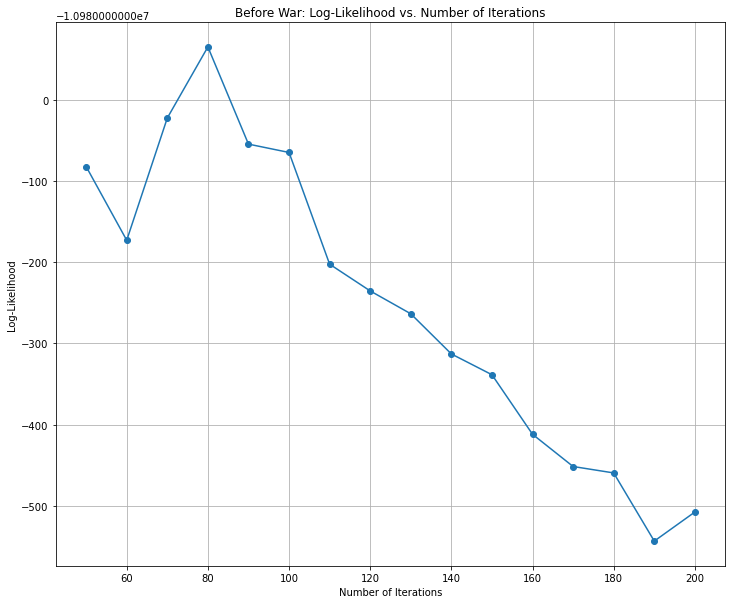

In [9]:
plt.figure(figsize=(12, 10))
# Plot log-likelihoods
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Before War: Log-Likelihood vs. Number of Iterations')
plt.grid(True)

## During and After War

Calculating Log-Likelihoods: 100%|█████████| 11/11 [3:12:46<00:00, 1051.47s/it]


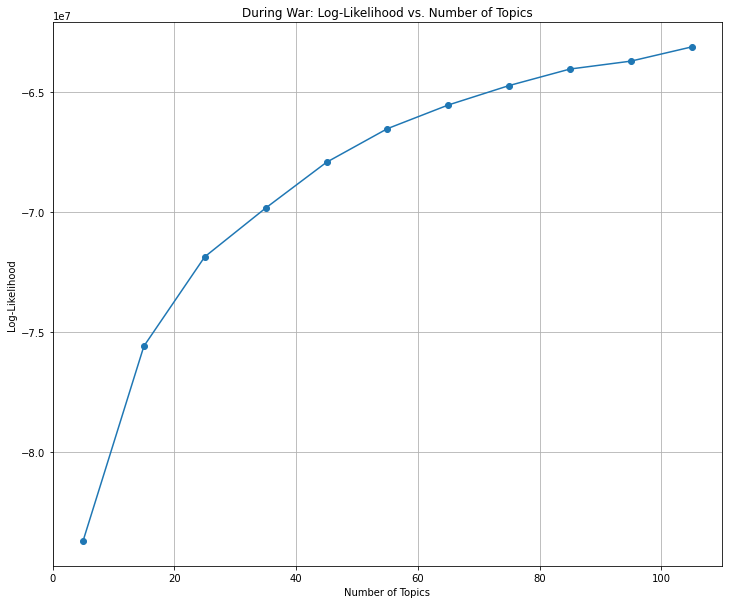

In [8]:
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_topics in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_topics = 5
max_topics = 100
step_size = 10
topic_range, log_likelihoods = calculate_log_likelihood(war_and_after_tfidf, min_topics, max_topics, step_size)

plt.figure(figsize=(12, 10))  
# Plot log-likelihoods
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood')
plt.title('During War: Log-Likelihood vs. Number of Topics')
plt.grid(True)
plt.show()

Calculating Log-Likelihoods: 100%|██████████| 4/4 [11:48:20<00:00, 10625.12s/it]


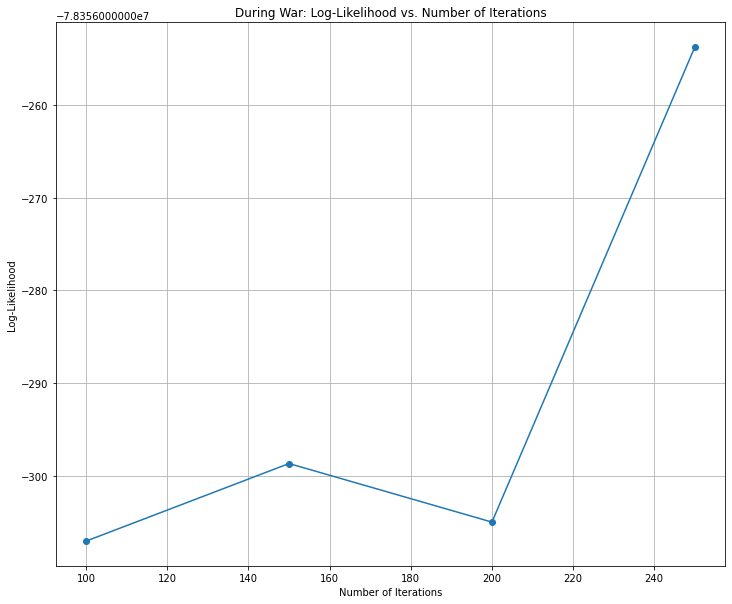

In [12]:
#Number of iterations
#Execution for this code is in Tester.ipynb
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_iter in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation( max_iter=num_iter, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_iter= 100
max_iter = 250
step_size = 50
topic_range, log_likelihoods = calculate_log_likelihood(war_and_after_tfidf, min_iter, max_iter, step_size)

# Plot log-likelihoods
plt.figure(figsize=(12, 10))  
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Log-Likelihood')
plt.title('During War: Log-Likelihood vs. Number of Iterations')
plt.grid(True)

In [46]:
n_top_words = 5
tf_feature_names = war_and_after_vect.get_feature_names()
print("After War 10 Clusters: ")
topics = dict()
for topic_idx, topic in enumerate(war_and_after_lda2.components_):
    topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic #%d:" % topic_idx)
    print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

# Gensim

In [69]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
import random

# Function to generate n-grams
def generate_ngrams(texts):
    n = random.choice([3, 4])  # Choose randomly between 3 and 4
    # Create phrases (trigram or quadgram)
    phrases = Phrases(texts, min_count=1, threshold=n)
    ngram = Phraser(phrases)

    # Apply phrases to texts
    return [ngram[text] for text in texts]

# Sampled datasets
before_war_titles = before_war_sample['cleaned_text'].apply(lambda x: x.split())
war_and_after_titles = war_and_after_sample['cleaned_text'].apply(lambda x: x.split())

# Generate n-grams for sampled datasets
before_war_ngrams = generate_ngrams(before_war_titles)
war_and_after_ngrams = generate_ngrams(war_and_after_titles)

# Create dictionaries for sampled datasets
before_war_dict = Dictionary(before_war_ngrams)
war_and_after_dict = Dictionary(war_and_after_ngrams)

# Filter out tokens based on frequency
before_war_dict.filter_extremes(no_below=10, no_above=0.85)
war_and_after_dict.filter_extremes(no_below=10, no_above=0.85)

# Convert text data to bag-of-words representation (corpora)
before_war_corpora = [before_war_dict.doc2bow(doc) for doc in before_war_ngrams]
war_and_after_corpora = [war_and_after_dict.doc2bow(doc) for doc in war_and_after_ngrams]


# with open('before_war_dict.pkl', 'wb') as f:
#     pickle.dump(before_war_dict, f)
# with open('war_and_after_dict.pkl', 'wb') as f:
#     pickle.dump(war_and_after_dict, f)


# with open('before_war_corpora.pkl', 'wb') as f:
#     pickle.dump(before_war_corpora, f)
# with open('war_and_after_corpora.pkl', 'wb') as f:
#     pickle.dump(war_and_after_corpora, f)

In [71]:
# with open('before_war_dict.pkl', 'wb') as f:
#     pickle.dump(before_war_sample_titles, f)
# with open('war_and_after_dict.pkl', 'wb') as f:
#     pickle.dump(war_and_after_sample_titles, f)


# with open('before_war_corpora.pkl', 'wb') as f:
#     pickle.dump(before_war_sample_corpora, f)
# with open('war_and_after_corpora.pkl', 'wb') as f:
#     pickle.dump(war_and_after_sample_corpora, f)

# with open('before_war_titles.pkl', 'wb') as f:
#     pickle.dump(before_war_sample_titles, f)
# with open('war_and_after_titles.pkl', 'wb') as f:
#     pickle.dump(war_and_after_sample_titles, f)

print("before_war corpora ", len(before_war_corpora))
print("war_and_after corpora: ", len(war_and_after_corpora))

before_war corpora  173585
war_and_after corpora:  1262618


Progress:   0%|                                          | 0/15 [05:17<?, ?it/s]
/home/mrtcloud-8/.local/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/home/mrtcloud-8/.local/lib/python3.9/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
Progress: 100%|███████████████████████████████████| 8/8 [05:07<00:00, 38.41s/it]


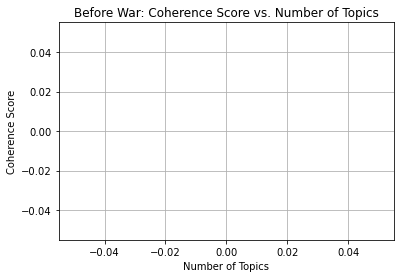

In [72]:
from tqdm import tqdm  # Import tqdm for progress bar
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# Define a range of values for the number of topics
min_topics = 5
max_topics = 40
step_size = 5
topic_range = range(min_topics, max_topics + step_size, step_size)

# Initialize lists to store metric scores
coherence_scores = []

# Initialize tqdm progress bar
progress_bar = tqdm(total=len(topic_range), desc='Progress', position=0)

# Iterate over the range of topic values
for num_topics in topic_range:
    # Train LDA model
    before_war_lda_model = LdaModel(corpus=before_war_corpora, id2word=before_war_dict, num_topics=num_topics, random_state=42)
    # Compute coherence score
    coherence_model = CoherenceModel(model=before_war_lda_model, texts=before_war_titles, dictionary=before_war_dict, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Append coherence score to list
    coherence_scores.append(coherence_score)
    
    # Update progress bar
    progress_bar.update(1)

# Close tqdm progress bar
progress_bar.close()

# Plot the coherence scores
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Before War: Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()


#based on this, it appears that the most ideal number of topics is 10 

In [73]:
# Assuming that corpus is your bag of words corpus and id2word is your dictionary
coherence_scores = []
passes_range = range(50, 200, 10)  # Adjust the range as needed

progress_bar = tqdm(total=len(passes_range), desc='Progress', position=0)
for passes in passes_range:
    print("entering")
    lda_model = LdaModel(corpus=before_war_corpora, id2word=before_war_dict, num_topics=10, passes=passes, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=before_war_titles, dictionary=before_war_dict, coherence='c_v')
    print("check")
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    progress_bar.update(1)

progress_bar.close()

# You can then plot the coherence scores to see how they change with the number of passes
import matplotlib.pyplot as plt

plt.plot(range(50, 200, 10), coherence_scores)
plt.xlabel('Number of Passes')
plt.ylabel('Coherence Score')
plt.title('Before War: Coherence Score vs. Number of Iterations')
plt.show()

#80 would be the approximate optimal pass number

Progress:   0%|                                          | 0/15 [00:00<?, ?it/s]

entering


KeyboardInterrupt: 

In [24]:
before_war_lda_model = LdaModel(
    corpus=before_war_corpora,
    id2word=before_war_dict,
    num_topics=10,
    passes=80,
    random_state=42
)

In [25]:
import pyLDAvis
import pyLDAvis.gensim


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=before_war_lda_model, corpus=before_war_corpora, dictionary=before_war_dict)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.262562 -0.030267       1        1  27.436326
3      0.278812  0.040294       2        1  20.114719
8      0.258497 -0.030364       3        1  19.479201
7      0.244826  0.017790       4        1  18.278378
1      0.076679  0.110003       5        1   4.305683
5     -0.146633 -0.359194       6        1   3.697824
0     -0.225532  0.044496       7        1   2.206041
4     -0.234310  0.106823       8        1   1.699666
9     -0.252027  0.051907       9        1   1.473531
6     -0.262873  0.048510      10        1   1.308632, topic_info=           Term          Freq         Total Category  logprob  loglift
40          amp   7053.000000   7053.000000  Default  30.0000  30.0000
58         keep  41970.000000  41970.000000  Default  29.0000  29.0000
348      please  10554.000000  10554.000000  Default  28.0000  28.0000
156     mention  10487.000000  10487.000000  Default  27.0000  27.0000
17      ukraine  14938.000000  14938.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
4698     unfair     65.779110     66.629649  Topic10  -4.8723   4.3233
1894          v     64.491509     65.342034  Topic10  -4.8920   4.3231
3617        uag     63.870976     64.721508  Topic10  -4.9017   4.3230
3565         rm     57.709633     58.560172  Topic10  -5.0031   4.3216
3931  stockpile     56.682767     57.533276  Topic10  -5.0211   4.3213

[507 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.160969  aaditharkawat
0         2  0.195011  aaditharkawat
0         3  0.290677  aaditharkawat
0         4  0.343493  aaditharkawat
0         5  0.009836  aaditharkawat
...     ...       ...            ...
1284      5  0.996552             xl
1493      4  0.998036        yeeeees
852       4  0.995619        youtube
2229      5  0.998619           zany
4033      5  0.988906             zn

[630 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 9, 8, 2, 6, 1, 5, 10, 7])

In [100]:

print(pyLDAvis.__version__)

2.1.2


In [16]:
print("Examples of n-grams:")
for i in range(5):  # Print 5 examples
    print(f"Example {i+1}:")
    print("Before War Sample N-grams:", before_war_sample_ngrams[i])
    print("War and After Sample N-grams:", war_and_after_sample_ngrams[i])
    print()

Examples of n-grams:
Example 1:
Before War Sample N-grams: ['aaditharkawat', 'love', 'russia_massing', 'troop_ukraine', 'border', 'ha_already', 'taken', 'piece', 'territory', 'may_invade', 'soon', 'somehow_u', 'fault']
War and After Sample N-grams: []

Example 2:
Before War Sample N-grams: ['aaprpsouthwest', 'sankofabrown', 'u_ha', 'funding', 'right_wing', 'nazi_group', 'since', 'russian_troop', 'amassing', 'near_border', 'similar', 'fashion', 'invaded_crimea', 'ha', 'biden', 'really', 'increased', 'rate', 'ukraine_join', 'nato']
War and After Sample N-grams: []

Example 3:
Before War Sample N-grams: ['aaron_mat', 'amp', 'andrew', 'cockburn', 'ukraine_yemen', 'u_arm', 'industry_reaps', 'spoil_war', 'zerohedge_com', 'geopolitical']
War and After Sample N-grams: []

Example 4:
Before War Sample N-grams: ['aaron', 'schwa', 'melindaharing', 'last', 'pro_russian', 'president', 'lose_power', 'without', 'invasion_occupation', 'maybe', 'putin', 'learn_something', 'american', 'keep_troop', 'bor